# **BTC TSA**

# **ARIMA**

In [ ]:
!pip install pmdarima --no-cache-dir

In [ ]:
from google.colab import files

# Upload your cleaned CSV file (choose one at a time)
uploaded = files.upload()


Saving cleaned_btc_data.csv to cleaned_btc_data (1).csv


In [ ]:
%pip install numpy==1.26.4

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

print("✅ All imports are now working fine!")


✅ All imports are now working fine!


In [ ]:
btc = pd.read_csv("/content/cleaned_btc_data.csv")

In [ ]:
# Set date as index
btc.set_index('Date', inplace=True)

# Use the 'Close' column for forecasting
btc_close = btc['Close']

# Split data into training and testing (e.g., 90% train, 10% test)
train_size = int(len(btc_close) * 0.9)
train, test = btc_close[0:train_size], btc_close[train_size:]

In [ ]:
# Auto ARIMA to find best parameters
model_auto = auto_arima(train, seasonal=False, trace=True)
print(model_auto.summary())

# Fit ARIMA model
model = ARIMA(train, order=model_auto.order)
model_fit = model.fit()

# Forecast the next len(test) points
forecast = model_fit.forecast(steps=len(test))

# Calculate error
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5854.901, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5847.132, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5848.911, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5848.920, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5847.890, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5850.908, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.674 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  329
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2921.566
Date:                Thu, 18 Dec 2025   AIC                           5847.132
Time:                        11:11:29   BIC                           5854.718
Sample:                    01-01-2024   HQIC                          5850.158
          

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


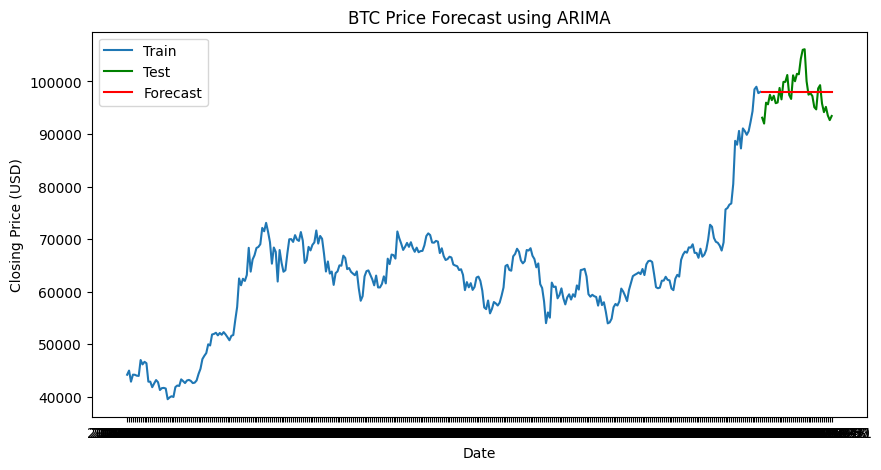

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('BTC Price Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Convert forecast to 1D numpy array
predicted = np.array(forecast).ravel()

# Ensure same length as test set
min_len = min(len(test), len(predicted))

# Align both arrays and index
actual = test.values[:min_len].ravel()
predicted = predicted[:min_len]
dates = test.index[:min_len]

# Build DataFrame safely
forecast_df = pd.DataFrame({
    'Date': dates,
    'Actual_Close': actual,
    'Predicted_Close': predicted
})

# Save CSV
forecast_df.to_csv("btc_arima_forecast.csv", index=False)

print("✅ Forecast CSV created successfully with", len(forecast_df), "rows")
print(forecast_df.head())


✅ Forecast CSV created successfully with 37 rows
         Date  Actual_Close  Predicted_Close
0  2024-11-25  93102.296875     98013.820312
1  2024-11-26  91985.320312     98013.820312
2  2024-11-27  95962.531250     98013.820312
3  2024-11-28  95652.468750     98013.820312
4  2024-11-29  97461.523438     98013.820312


# **SARIMA**

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
btc = pd.read_csv("/content/cleaned_btc_data.csv")   # or path where you uploaded file
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.sort_values('Date').reset_index(drop=True)

btc.set_index('Date', inplace=True)
# If your data has missing days and you want to ensure daily frequency:
btc = btc.asfreq('D')            # inserts NaN for missing dates
btc['Close'] = btc['Close'].interpolate()   # simple interpolation to fill holes (optional)


In [ ]:
series = btc['Close'].astype(float)

train_size = int(len(series) * 0.9)
train, test = series.iloc[:train_size], series.iloc[train_size:]

print(f"Total points: {len(series)}, Train: {len(train)}, Test: {len(test)}")
m = 7

print("Running auto_arima to suggest orders (this may take a minute)...")
auto_model = auto_arima(train,
                        seasonal=True,
                        m=m,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        max_p=5, max_q=5, max_P=2, max_Q=2)

print("\nAuto ARIMA summary:")
print(auto_model.summary())

order = auto_model.order
seasonal_order = auto_model.seasonal_order
print("Selected order:", order)
print("Selected seasonal_order:", seasonal_order)

# ---Fit SARIMAX using statsmodels for richer output ---
model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

# ---Forecast on test set length and compute error ---
n_test = len(test)
forecast_result = model_fit.get_forecast(steps=n_test)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)

# Evaluation
rmse = sqrt(mean_squared_error(test, forecast))
print(f"Test RMSE: {rmse:.4f}")

Total points: 366, Train: 329, Test: 37
Running auto_arima to suggest orders (this may take a minute)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=5854.178, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5847.132, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5848.200, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5848.459, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5847.890, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=5846.299, Time=0.07 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=5846.652, Time=0.19 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5847.997, Time=0.25 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=5846.553, Time=0.06 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=5842.562, Time=0.29 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=5844.561, Time=0.57 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=5842.700, Time=0.27 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=5844.232, Time=0.3

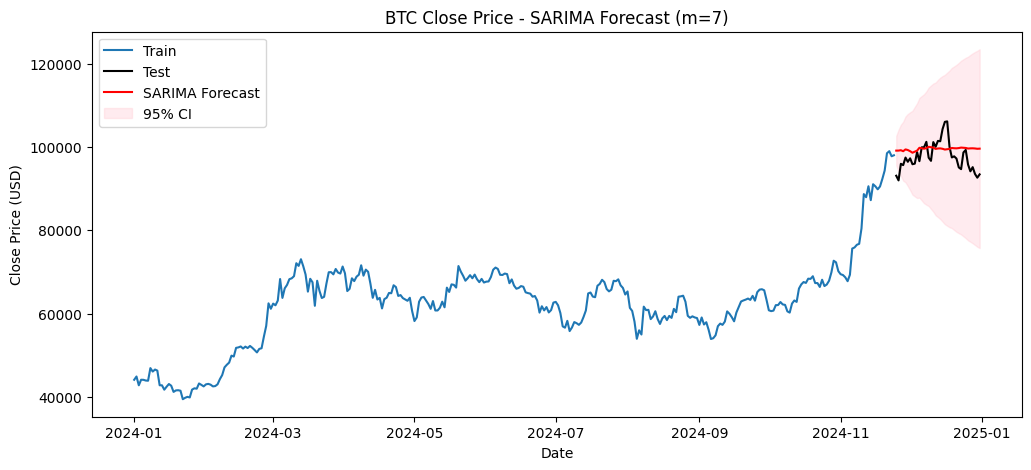

In [ ]:
# --- 8) Plot train / test / forecast with confidence intervals ---
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(forecast.index, forecast, label='SARIMA Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3, label='95% CI')
plt.title(f'BTC Close Price - SARIMA Forecast (m={m})')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

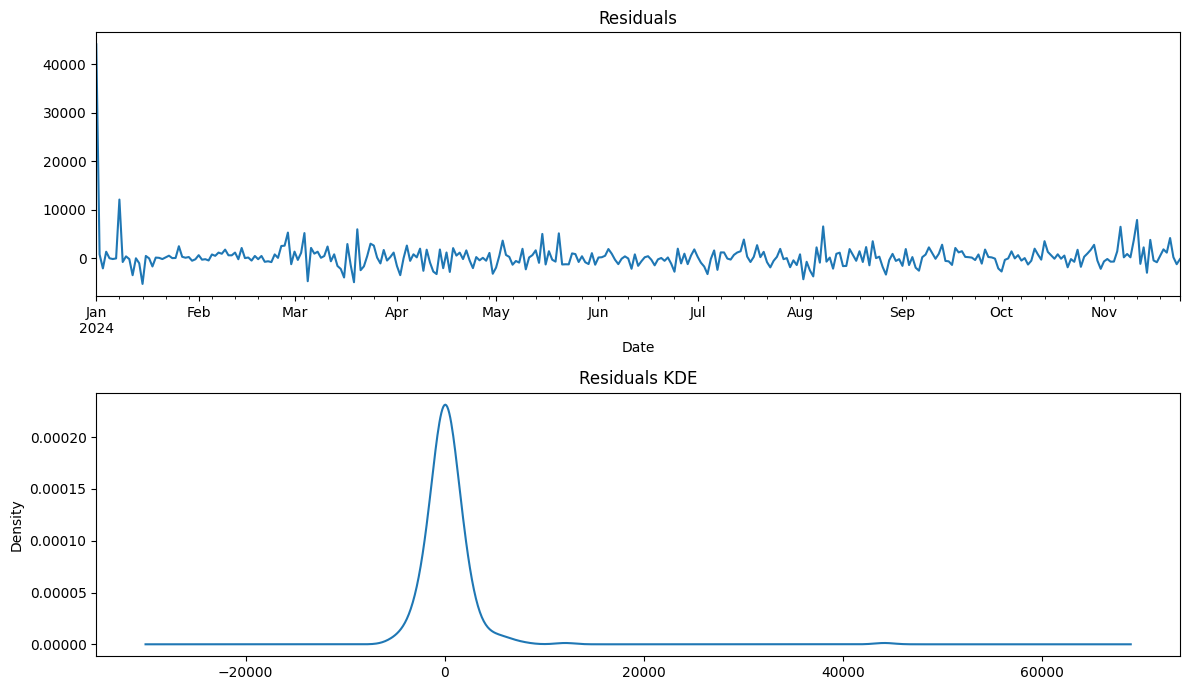

In [ ]:
# --- 9) Residual diagnostics (quick) ---
residuals = model_fit.resid
fig, ax = plt.subplots(2,1, figsize=(12,7))
residuals.plot(ax=ax[0], title='Residuals')
residuals.plot(kind='kde', ax=ax[1], title='Residuals KDE')
plt.tight_layout()
plt.show()

In [ ]:
# Optionally run Ljung-Box test to check residual autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box test (lag=10):")
print(lb_test)

# --- 10) Forecast future days (e.g., next 30 days) and save to CSV ---
future_days = 30
future_result = model_fit.get_forecast(steps=future_days)
future_forecast = future_result.predicted_mean
future_conf_int = future_result.conf_int()

future_df = pd.DataFrame({
    'Date': future_forecast.index,
    'Forecast': future_forecast.values,
    'Lower_CI': future_conf_int.iloc[:,0].values,
    'Upper_CI': future_conf_int.iloc[:,1].values
})
future_df.set_index('Date', inplace=True)
future_df.to_csv("btc_sarima_future_30days.csv")
print("Saved forecast for next", future_days, "days to 'btc_sarima_future_30days.csv'")

# Show top of forecast
display(future_df.head())

Ljung-Box test (lag=10):
     lb_stat  lb_pvalue
10  7.782543   0.650068
Saved forecast for next 30 days to 'btc_sarima_future_30days.csv'


,Forecast,Lower_CI,Upper_CI
Date,,,
2024-11-25,99128.678567,95599.297826,102658.059308
2024-11-26,99135.967067,94144.668957,104127.265178
2024-11-27,99223.207925,93110.141163,105336.274688
2024-11-28,98989.571737,91930.810255,106048.333219
2024-11-29,99420.015051,91528.079796,107311.950306


# **Prophet**

In [ ]:
%pip uninstall prophet pystan cmdstanpy -y
# Fresh, compatible install
%pip install prophet cmdstanpy --quiet


Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

print("✅ Prophet backend OK")

✅ Prophet backend OK


In [ ]:
# 2️⃣ Load your cleaned BTC data
btc = pd.read_csv("/content/cleaned_btc_data.csv")
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.sort_values('Date')

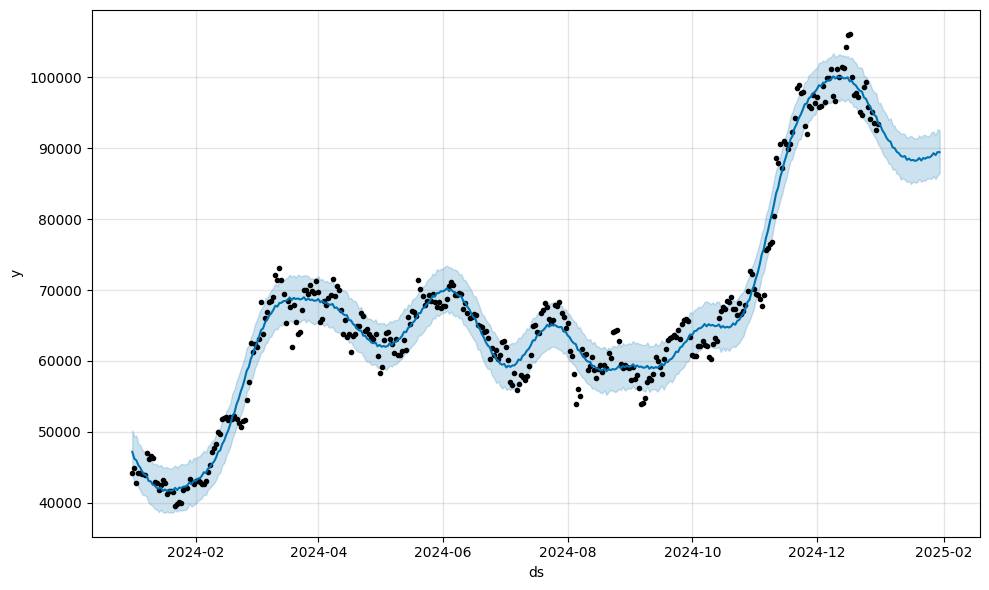

In [ ]:
btc = pd.read_csv("/content/cleaned_btc_data.csv")
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.sort_values('Date')
prophet_df = btc[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prophet_df)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot(forecast)
plt.show()

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("btc_prophet_forecast_30days.csv", index=False)
print("✅ Prophet forecast saved to 'btc_prophet_forecast_30days.csv'")

✅ Prophet forecast saved to 'btc_prophet_forecast_30days.csv'


# LSTM

In [ ]:
# 1️⃣ Install required libs (only if missing)
%pip install tensorflow scikit-learn --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [ ]:
pip install tensorflow


In [ ]:
btc = pd.read_csv("/content/cleaned_btc_data.csv")
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.sort_values('Date')

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0745
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0089
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0068
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0058
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0048
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0053
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0039
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0035
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0032
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029
Epoc

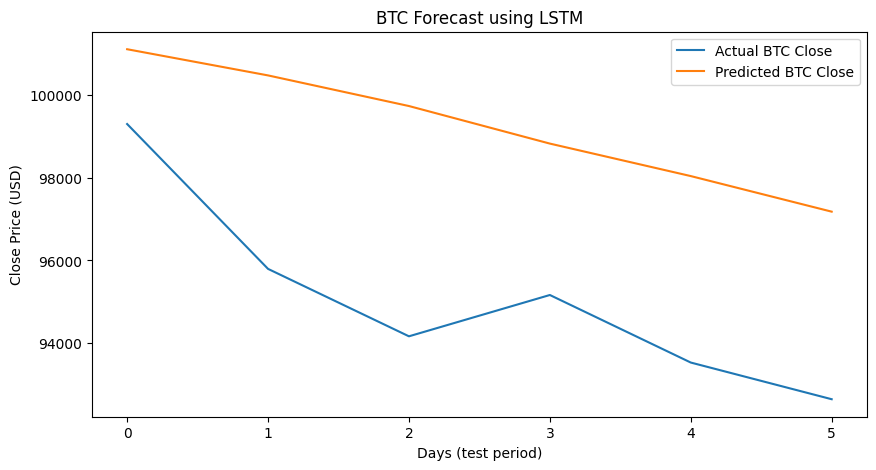

In [ ]:
# 3️⃣ Use Close prices and scale them between 0–1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(np.array(btc['Close']).reshape(-1,1))

# 4️⃣ Create training and test sets
train_size = int(len(scaled_close) * 0.9)
train_data, test_data = scaled_close[:train_size], scaled_close[train_size:]

# 5️⃣ Function to create (X, y) sequences
def create_dataset(dataset, time_step=30):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 30  # use past 30 days to predict next day
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape inputs to [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 6️⃣ Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step,1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# 7️⃣ Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 8️⃣ Predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# 9️⃣ Inverse transform to get real prices
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
actual_test = scaler.inverse_transform(y_test.reshape(-1,1))

# 10️⃣ Plot results
plt.figure(figsize=(10,5))
plt.plot(actual_test, label='Actual BTC Close')
plt.plot(test_pred, label='Predicted BTC Close')
plt.title('BTC Forecast using LSTM')
plt.xlabel('Days (test period)')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Save predicted vs actual prices for test period
lstm_forecast_df = pd.DataFrame({
    'Actual_Close': actual_test.flatten(),
    'Predicted_Close': test_pred.flatten()
})
lstm_forecast_df.to_csv("btc_lstm_forecast.csv", index=False)
print("✅ LSTM forecast saved as btc_lstm_forecast.csv")


✅ LSTM forecast saved as btc_lstm_forecast.csv


In [ ]:
features = ['Volume', 'RSI', 'MACD', 'Volatility']
corrs = {}

for f in features:
    corrs[f] = df[f].corr(df['Return'])

feature_importance = pd.DataFrame({
    'Feature': corrs.keys(),
    'Correlation': corrs.values()
})

feature_importance.to_csv("btc_feature_importance.csv", index=False)


NameError: name 'df' is not defined

# **Dodge TSA**

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Classical + ML tools
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Prophet
from prophet import Prophet

# LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving cleaned_doge_data.csv to cleaned_doge_data.csv


In [ ]:
# --- Load Cleaned DOGE Data ---
doge = pd.read_csv("/content/cleaned_doge_data.csv")   # ⬅️ Change path if needed
doge['Date'] = pd.to_datetime(doge['Date'])
doge = doge.sort_values('Date')
doge.set_index('Date', inplace=True)

# **ARIMA**

In [ ]:
train_size = int(len(doge) * 0.9)
train, test = doge['Close'][:train_size], doge['Close'][train_size:]

auto_model = auto_arima(train, seasonal=False, trace=False)
order = auto_model.order
model = ARIMA(train, order=order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Save ARIMA forecast
arima_df = pd.DataFrame({
    'Date': test.index[:len(forecast)],
    'Actual_Close': test.values[:len(forecast)],
    'Predicted_Close': np.array(forecast)
})
arima_df.to_csv("doge_arima_forecast.csv", index=False)
print("✅ ARIMA forecast saved as doge_arima_forecast.csv")

✅ ARIMA forecast saved as doge_arima_forecast.csv


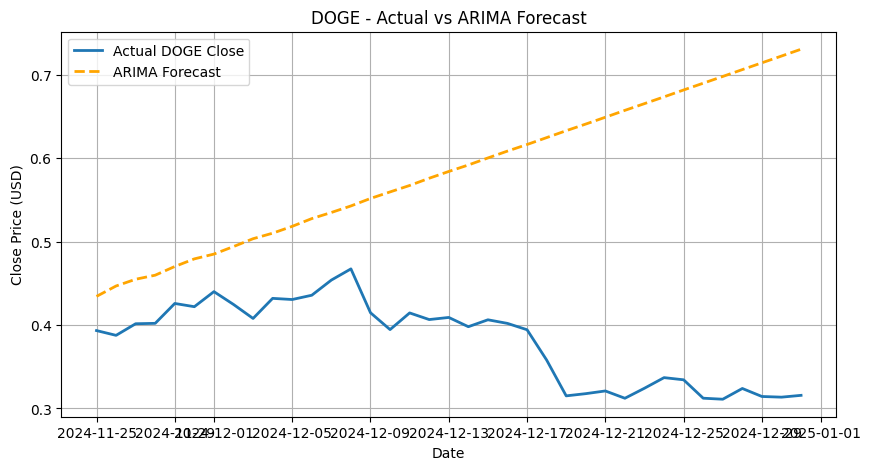

In [ ]:
# --- Plot Actual vs Predicted DOGE Close Prices ---
plt.figure(figsize=(10,5))
plt.plot(arima_df['Date'], arima_df['Actual_Close'], label='Actual DOGE Close', linewidth=2)
plt.plot(arima_df['Date'], arima_df['Predicted_Close'], label='ARIMA Forecast', linestyle='--', color='orange', linewidth=2)
plt.title("DOGE - Actual vs ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


# **SARIMA**

In [ ]:
auto_model_s = auto_arima(train, seasonal=True, m=7, trace=False)
order_s = auto_model_s.order
seasonal_order_s = auto_model_s.seasonal_order

sarima_model = SARIMAX(train, order=order_s, seasonal_order=seasonal_order_s)
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.get_forecast(steps=len(test)).predicted_mean

sarima_df = pd.DataFrame({
    'Date': test.index[:len(sarima_forecast)],
    'Actual_Close': test.values[:len(sarima_forecast)],
    'Predicted_Close': sarima_forecast.values
})
sarima_df.to_csv("doge_sarima_forecast.csv", index=False)
print("✅ SARIMA forecast saved as doge_sarima_forecast.csv")

✅ SARIMA forecast saved as doge_sarima_forecast.csv


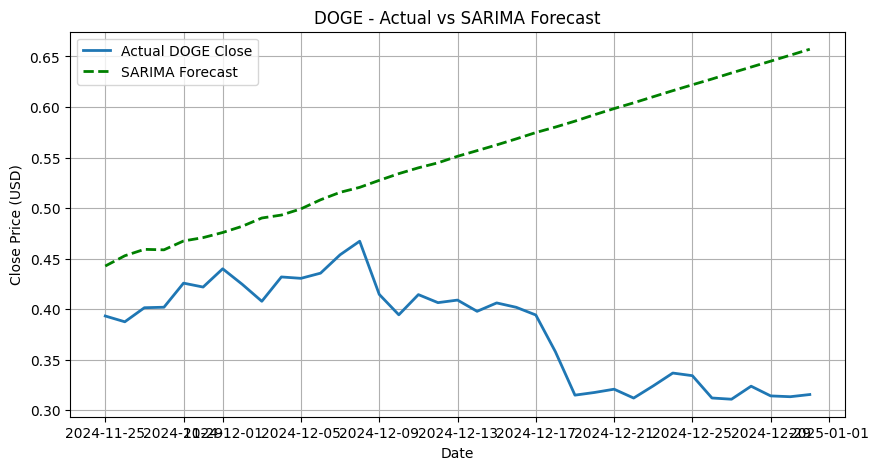

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(sarima_df['Date'], sarima_df['Actual_Close'], label='Actual DOGE Close', linewidth=2)
plt.plot(sarima_df['Date'], sarima_df['Predicted_Close'], label='SARIMA Forecast', linestyle='--', color='green', linewidth=2)
plt.title("DOGE - Actual vs SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


# **Prophet**

✅ Prophet forecast saved as doge_prophet_forecast.csv


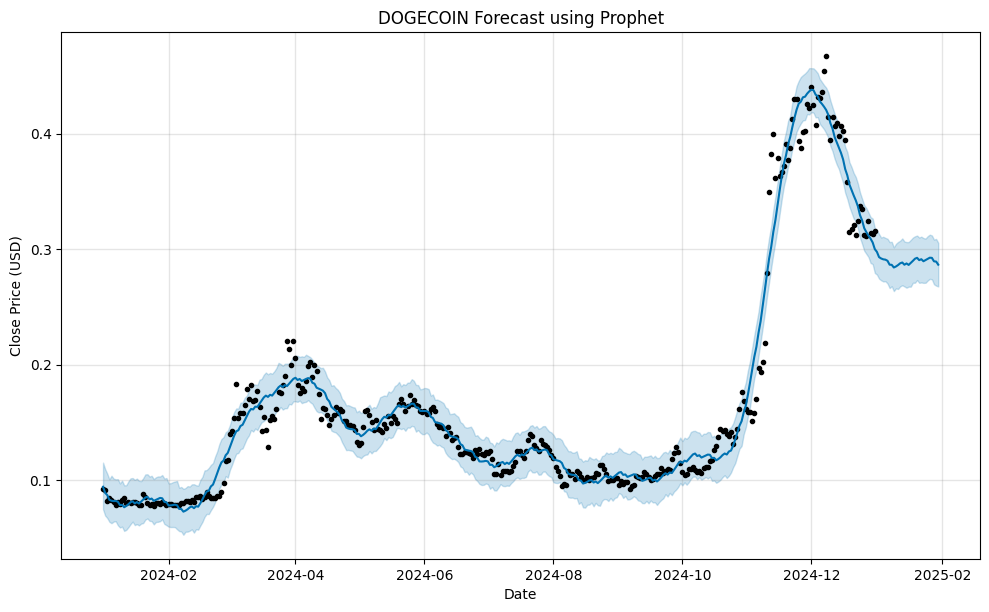

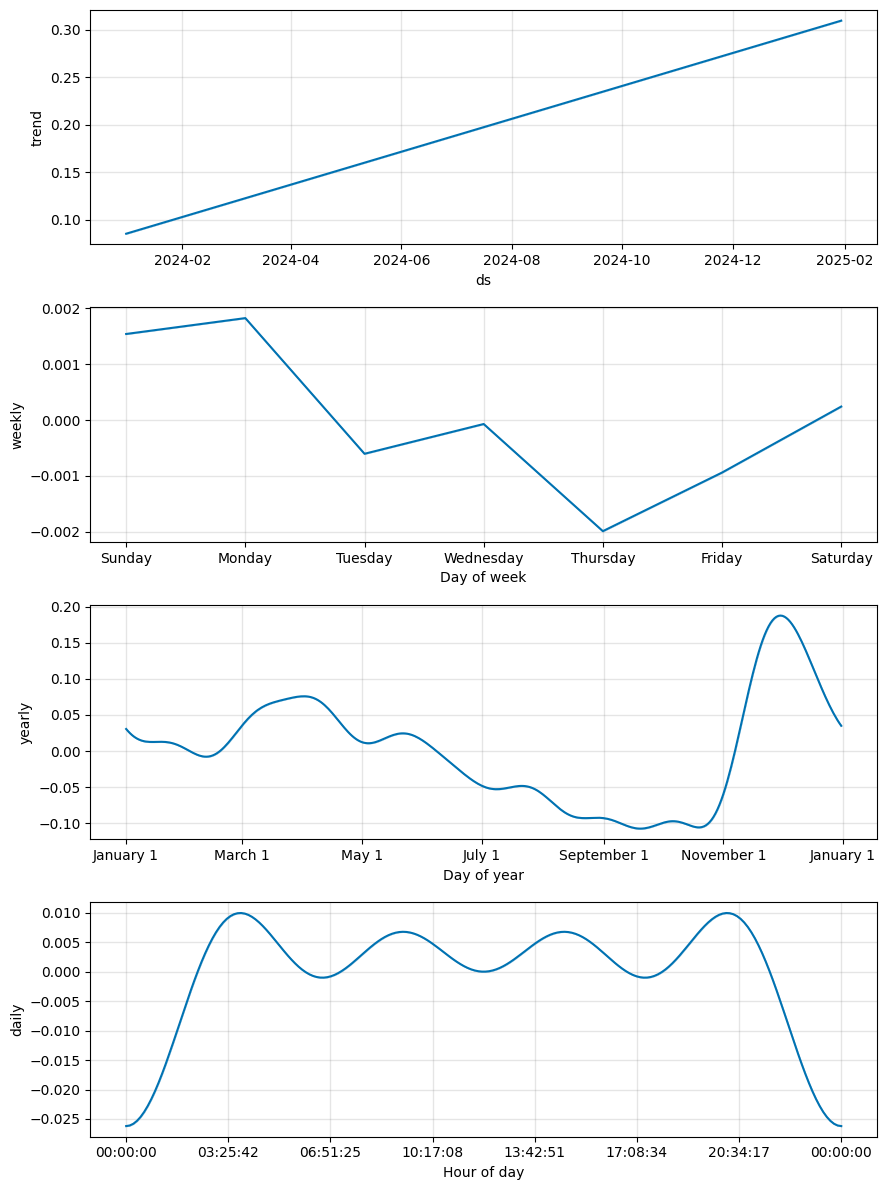

In [ ]:
doge = pd.read_csv("/content/cleaned_doge_data.csv")
doge['Date'] = pd.to_datetime(doge['Date'])
doge = doge.sort_values('Date')

prophet_df = doge[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prophet_df)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv("doge_prophet_forecast.csv", index=False)
print("✅ Prophet forecast saved as doge_prophet_forecast.csv")

fig1 = model.plot(forecast)
plt.title("DOGECOIN Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.show()

model.plot_components(forecast)
plt.show()


# **LSTM**

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0301
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0109
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0061
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0039
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0042
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0033
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0035
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0034
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0033
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0028
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0027
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0034
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0025
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0036
Ep

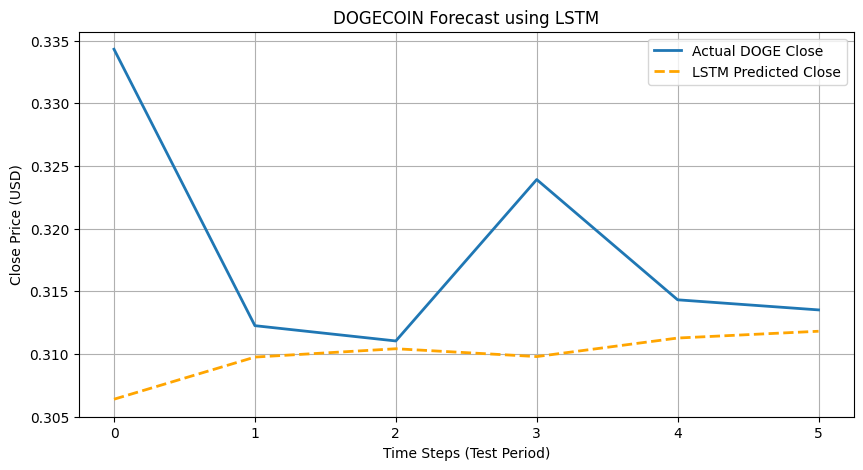

In [ ]:
# --- LSTM FORECAST FOR DOGECOIN ---

# 1️⃣ Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 2️⃣ Load Data
doge = pd.read_csv("/content/cleaned_doge_data.csv")
doge['Date'] = pd.to_datetime(doge['Date'])
doge = doge.sort_values('Date')

# 3️⃣ Prepare Close Prices
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(doge['Close']).reshape(-1,1))

# 4️⃣ Split Train-Test (90-10)
train_size = int(len(scaled_data)*0.9)
train_data = scaled_data[0:train_size]
test_data = scaled_data[train_size:]

# 5️⃣ Create Time-Step Data
def create_dataset(dataset, time_step=30):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        Y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(Y)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 6️⃣ Build Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step,1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# 7️⃣ Train Model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 8️⃣ Predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# 9️⃣ Inverse Transform
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
actual_test = scaler.inverse_transform(y_test.reshape(-1,1))

# 10️⃣ Save to CSV
lstm_df = pd.DataFrame({
    'Actual_Close': actual_test.flatten(),
    'Predicted_Close': test_pred.flatten()
})
lstm_df.to_csv("doge_lstm_forecast.csv", index=False)
print("✅ LSTM forecast saved as doge_lstm_forecast.csv")

# 11️⃣ Plot Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(actual_test, label='Actual DOGE Close', linewidth=2)
plt.plot(test_pred, label='LSTM Predicted Close', linestyle='--', color='orange', linewidth=2)
plt.title("DOGECOIN Forecast using LSTM")
plt.xlabel("Time Steps (Test Period)")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


# **ETH TSA**

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving cleaned_eth_data.csv to cleaned_eth_data.csv


✅ ARIMA forecast saved as eth_arima_forecast.csv


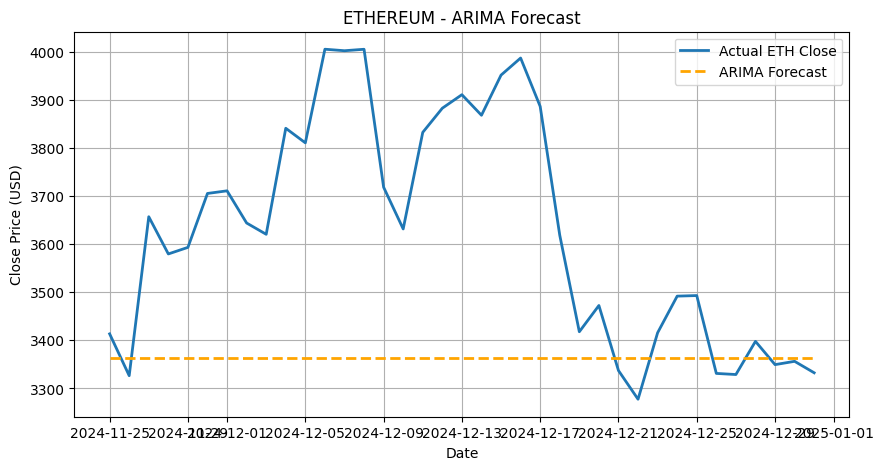

In [ ]:
# --- ETHEREUM ARIMA FORECASTING ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Load cleaned ETH data
eth = pd.read_csv("/content/cleaned_eth_data.csv")
eth['Date'] = pd.to_datetime(eth['Date'])
eth = eth.sort_values('Date')
eth.set_index('Date', inplace=True)

# Train-Test Split
train_size = int(len(eth) * 0.9)
train, test = eth['Close'][:train_size], eth['Close'][train_size:]

# Fit ARIMA
auto_model = auto_arima(train, seasonal=False, trace=False)
order = auto_model.order
model = ARIMA(train, order=order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Save forecast
arima_df = pd.DataFrame({
    'Date': test.index,
    'Actual_Close': test.values,
    'Predicted_Close': np.array(forecast)
})
arima_df.to_csv("eth_arima_forecast.csv", index=False)
print("✅ ARIMA forecast saved as eth_arima_forecast.csv")

# Plot
plt.figure(figsize=(10,5))
plt.plot(arima_df['Date'], arima_df['Actual_Close'], label='Actual ETH Close', linewidth=2)
plt.plot(arima_df['Date'], arima_df['Predicted_Close'], label='ARIMA Forecast', linestyle='--', color='orange', linewidth=2)
plt.title("ETHEREUM - ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


# **SARIMA**

✅ SARIMA forecast saved as eth_sarima_forecast.csv


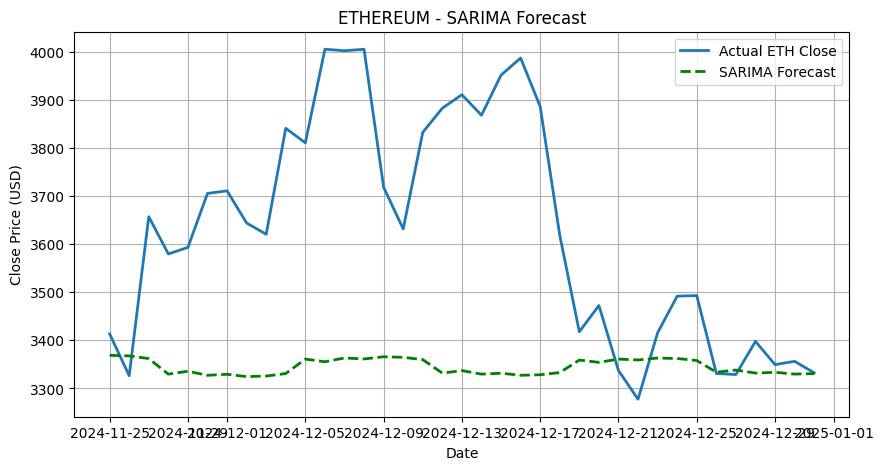

In [ ]:
# --- ETHEREUM SARIMA FORECASTING ---
from statsmodels.tsa.statespace.sarimax import SARIMAX

auto_model_s = auto_arima(train, seasonal=True, m=7, trace=False)
order_s = auto_model_s.order
seasonal_order_s = auto_model_s.seasonal_order

sarima_model = SARIMAX(train, order=order_s, seasonal_order=seasonal_order_s)
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.get_forecast(steps=len(test)).predicted_mean

# Save forecast
sarima_df = pd.DataFrame({
    'Date': test.index,
    'Actual_Close': test.values,
    'Predicted_Close': sarima_forecast.values
})
sarima_df.to_csv("eth_sarima_forecast.csv", index=False)
print("✅ SARIMA forecast saved as eth_sarima_forecast.csv")

# Plot
plt.figure(figsize=(10,5))
plt.plot(sarima_df['Date'], sarima_df['Actual_Close'], label='Actual ETH Close', linewidth=2)
plt.plot(sarima_df['Date'], sarima_df['Predicted_Close'], label='SARIMA Forecast', linestyle='--', color='green', linewidth=2)
plt.title("ETHEREUM - SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


# **PROPHET**

✅ Prophet forecast saved as eth_prophet_forecast.csv


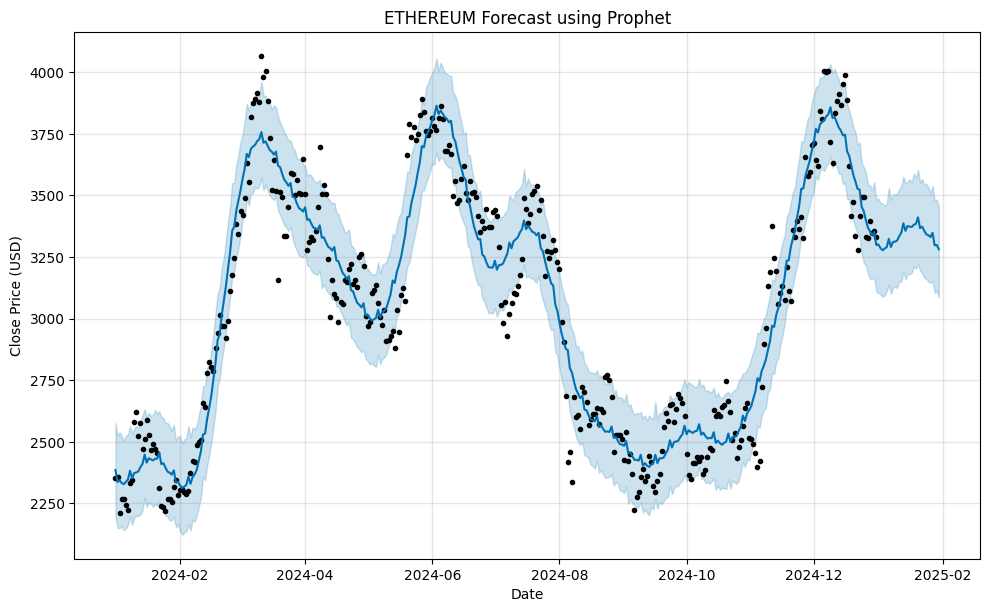

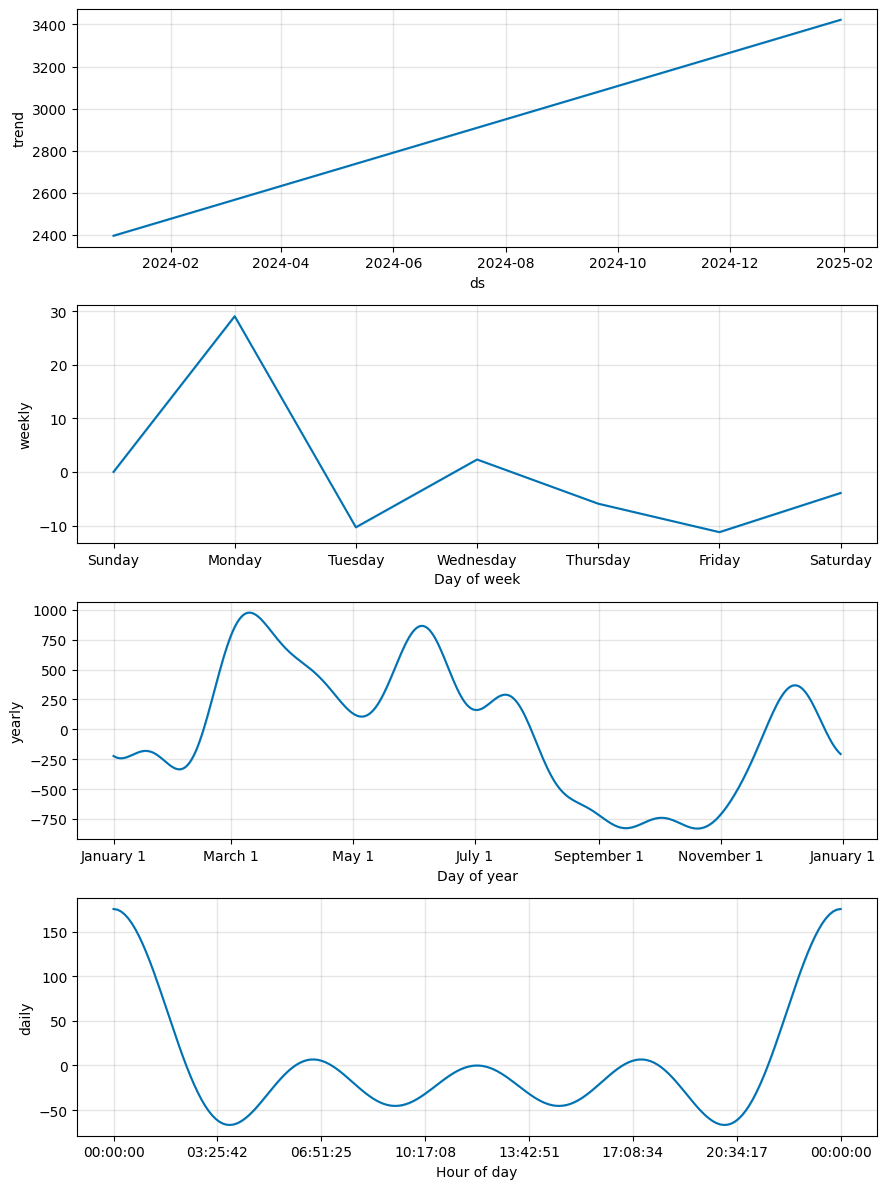

In [ ]:
# --- ETHEREUM PROPHET FORECASTING ---
from prophet import Prophet

prophet_df = eth.reset_index()[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prophet_df)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv("eth_prophet_forecast.csv", index=False)
print("✅ Prophet forecast saved as eth_prophet_forecast.csv")

fig1 = model.plot(forecast)
plt.title("ETHEREUM Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.show()

model.plot_components(forecast)
plt.show()


# **LSTM**

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1399
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0252
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0223
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0175
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0159
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0138
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0129
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0135
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0116
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0120
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0098
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0094
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0091
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0076
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0084
Epoc

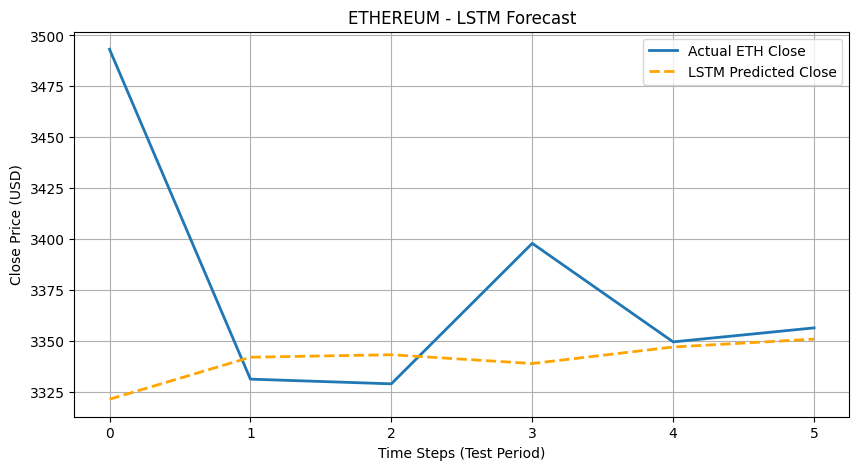

In [ ]:
# --- ETHEREUM LSTM FORECASTING ---
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(np.array(eth['Close']).reshape(-1,1))

# Train-Test split
train_size = int(len(scaled)*0.9)
train_data, test_data = scaled[0:train_size,:], scaled[train_size:,:]

# Create datasets
def create_dataset(dataset, time_step=30):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        Y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(Y)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step,1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict
test_pred = model.predict(X_test)
test_pred = scaler.inverse_transform(test_pred)
actual = scaler.inverse_transform(y_test.reshape(-1,1))

# Save CSV
lstm_df = pd.DataFrame({
    'Actual_Close': actual.flatten(),
    'Predicted_Close': test_pred.flatten()
})
lstm_df.to_csv("eth_lstm_forecast.csv", index=False)
print("✅ LSTM forecast saved as eth_lstm_forecast.csv")

# Plot
plt.figure(figsize=(10,5))
plt.plot(actual, label='Actual ETH Close', linewidth=2)
plt.plot(test_pred, label='LSTM Predicted Close', linestyle='--', color='orange', linewidth=2)
plt.title("ETHEREUM - LSTM Forecast")
plt.xlabel("Time Steps (Test Period)")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import files
files.download("btc_arima_forecast.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("btc_sarima_future_30days.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("btc_lstm_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("btc_prophet_forecast_30days.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("doge_arima_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("doge_sarima_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("doge_prophet_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("doge_lstm_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("eth_arima_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("eth_sarima_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("eth_prophet_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("eth_lstm_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import glob
import os

# =============================
# CONFIGURATION
# =============================
PATH = "."  # same folder as all CSVs

# Load cleaned actual data per coin
btc = pd.read_csv(os.path.join(PATH, "cleaned_btc_data.csv"), parse_dates=['Date'])
eth = pd.read_csv(os.path.join(PATH, "cleaned_eth_data.csv"), parse_dates=['Date'])
doge = pd.read_csv(os.path.join(PATH, "cleaned_doge_data.csv"), parse_dates=['Date'])

btc['Coin'] = 'BTC'
eth['Coin'] = 'ETH'
doge['Coin'] = 'DOGE'

# Combine all actuals
actuals = pd.concat([btc[['Coin', 'Date', 'Close']],
                     eth[['Coin', 'Date', 'Close']],
                     doge[['Coin', 'Date', 'Close']]],
                    ignore_index=True)
actuals.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# =============================
# Helper function
# =============================
def standardize_forecast_df(df):
    for col in ['ds', 'date', 'DATE']:
        if col in df.columns:
            df.rename(columns={col: 'Date'}, inplace=True)
    if 'Date' not in df.columns:
        raise ValueError("No 'Date' column found.")
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    pred_candidates = ['Predicted_Close', 'Forecast', 'Predicted', 'yhat', 'y_pred']
    for c in pred_candidates:
        if c in df.columns:
            df.rename(columns={c: 'Predicted_Close'}, inplace=True)
            break
    if 'Predicted_Close' not in df.columns:
        df['Predicted_Close'] = pd.NA

    for c in ['yhat_lower', 'Lower', 'lower']:
        if c in df.columns:
            df.rename(columns={c: 'Lower'}, inplace=True)
            break
    for c in ['yhat_upper', 'Upper', 'upper']:
        if c in df.columns:
            df.rename(columns={c: 'Upper'}, inplace=True)
            break
    if 'Lower' not in df.columns:
        df['Lower'] = pd.NA
    if 'Upper' not in df.columns:
        df['Upper'] = pd.NA

    if 'Actual' in df.columns:
        df.rename(columns={'Actual': 'Actual_Close'}, inplace=True)
    elif 'Close' in df.columns:
        df.rename(columns={'Close': 'Actual_Close'}, inplace=True)
    else:
        df['Actual_Close'] = pd.NA

    return df[['Date', 'Predicted_Close', 'Lower', 'Upper', 'Actual_Close']]

# =============================
# Collect forecast CSVs
# =============================
forecast_files = glob.glob(os.path.join(PATH, "*_forecast*.csv"))
combined_list = []

for f in forecast_files:
    fname = os.path.basename(f).lower()
    coin = 'UNKNOWN'
    if 'btc' in fname:
        coin = 'BTC'
    elif 'eth' in fname:
        coin = 'ETH'
    elif 'doge' in fname:
        coin = 'DOGE'

    model = 'UNKNOWN'
    if 'arima' in fname:
        model = 'ARIMA'
    elif 'sarima' in fname:
        model = 'SARIMA'
    elif 'lstm' in fname:
        model = 'LSTM'
    elif 'prophet' in fname:
        model = 'PROPHET'

    print(f"Processing {fname} -> {coin}/{model}")

    try:
        df = pd.read_csv(f)
        df_std = standardize_forecast_df(df)
        df_std['Coin'] = coin
        df_std['Model'] = model
        combined_list.append(df_std)
    except Exception as e:
        print(f"⚠ Skipping {fname} - {e}")

# Combine and merge with actuals
forecast_combined = pd.concat(combined_list, ignore_index=True)
merged = forecast_combined.merge(actuals, on=['Coin', 'Date'], how='left', suffixes=('', '_actual'))

merged['Actual_Close'] = merged['Actual_Close'].combine_first(merged['Actual_Close_actual'])
merged.drop(columns=['Actual_Close_actual'], inplace=True)

# Reorder and save
cols = ['Coin', 'Date', 'Model', 'Predicted_Close', 'Lower', 'Upper', 'Actual_Close']
merged = merged[cols]
merged.to_csv("forecast_combined.csv", index=False)

print(f"\n✅ forecast_combined.csv created with {len(merged)} rows.")


Processing eth_sarima_forecast.csv -> ETH/ARIMA
Processing btc_prophet_forecast_30days.csv -> BTC/PROPHET
Processing doge_lstm_forecast.csv -> DOGE/LSTM
⚠ Skipping doge_lstm_forecast.csv - No 'Date' column found.
Processing btc_arima_forecast.csv -> BTC/ARIMA
Processing btc_lstm_forecast.csv -> BTC/LSTM
⚠ Skipping btc_lstm_forecast.csv - No 'Date' column found.
Processing doge_arima_forecast.csv -> DOGE/ARIMA
Processing doge_prophet_forecast.csv -> DOGE/PROPHET
Processing doge_sarima_forecast.csv -> DOGE/ARIMA
Processing eth_lstm_forecast.csv -> ETH/LSTM
⚠ Skipping eth_lstm_forecast.csv - No 'Date' column found.
Processing eth_arima_forecast.csv -> ETH/ARIMA
Processing eth_prophet_forecast.csv -> ETH/PROPHET

✅ forecast_combined.csv created with 1373 rows.


In [ ]:
files.download("forecast_combined.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>